<a href="https://colab.research.google.com/github/MarieHabanova/ZP/blob/main/Pracovn%C3%AD_ZP_Klasifikace_emoc%C3%AD_v_textu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finální projekt - Klasifikace emocí v **textu**

## **DSCZ4083 - Data Science**

Tento notebook obsahuje kompletní řešení pro klasifikaci emocí v textových datech z Twitteru.

# Nastavení prostředí a import **knihoven**

In [22]:
%matplotlib inline
from IPython import get_ipython
from IPython.display import display
# import os
import kagglehub
import matplotlib.pyplot as plt
# %%
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


In [38]:
 Import knihoven pro zpracování textu
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

#  Načteme data z kagglu -> výsledek bude dataframe




In [24]:
# Stáhnutí z Kaggle
path = kagglehub.dataset_download("nelgiriyewithana/emotions")
df = pd.read_csv(path + '/text.csv').rename(columns = {"Unnamed: 0": "id"})
df.head()

,id,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


### Redukce na 2 sloupce - text a label

In [25]:
df = df.drop("id", axis=1)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### Explorace dat

In [26]:
# Základní informace o datasetu
print("=== ZÁKLADNÍ INFORMACE O DATASETU ===")
print(f"Počet záznamů: {len(df):,}")
print(f"Počet sloupců: {df.shape[1]}")

# Přejmenování sloupců
df = df.rename(columns={"Unnamed: 0": "id"})
print("\nSloupce:", df.columns.tolist())

# Zobrazení prvních řádků
print("\nPrvních 5 řádků:")
df.head()

=== ZÁKLADNÍ INFORMACE O DATASETU ===
Počet záznamů: 416,809
Počet sloupců: 2

Sloupce: ['text', 'label']

Prvních 5 řádků:


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [28]:
df.isnull().sum()

,0
text,0
label,0


In [29]:
df.describe()

,label
count,416809.000000
mean,1.554271
std,1.490453
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [30]:
df['label'].value_counts()

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


In [31]:
label_to_emotion = {
    0: "smutek",
    1: "radost",
    2: "hněv",
    3: "strach",
    4: "odpor",
    5: "překvapení"
}
df["emotion"] = df["label"].map(label_to_emotion)
df.head()

,text,label,emotion
0,i just feel really helpless and heavy hearted,4,odpor
1,ive enjoyed being able to slouch about relax a...,0,smutek
2,i gave up my internship with the dmrg and am f...,4,odpor
3,i dont know i feel so lost,0,smutek
4,i am a kindergarten teacher and i am thoroughl...,4,odpor


In [32]:
n_classes = df['label'].nunique()
n_classes

6

=== DISTRIBUCE EMOCÍ ===
emotion
radost        141067
smutek        121187
strach         57317
odpor          47712
hněv           34554
překvapení     14972
Name: count, dtype: int64

Počet unikátních emocí: 6


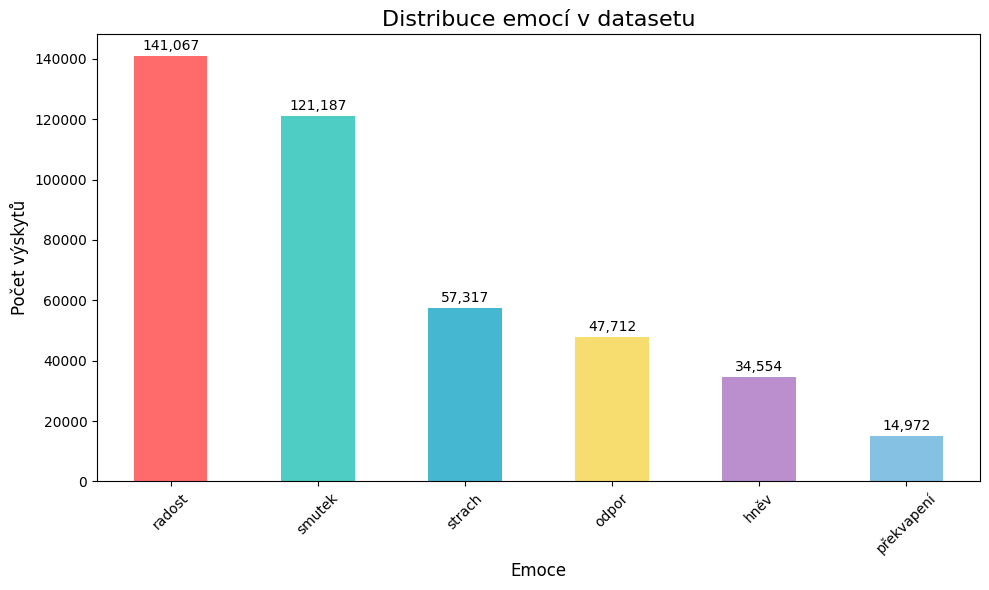

In [33]:
# Distribuce emocí
print("=== DISTRIBUCE EMOCÍ ===")
emotion_counts = df['emotion'].value_counts()
print(emotion_counts)
print(f"\nPočet unikátních emocí: {df['label'].nunique()}")

# Vizualizace distribuce
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#F7DC6F', '#BB8FCE', '#85C1E2'])
plt.title('Distribuce emocí v datasetu', fontsize=16)
plt.xlabel('Emoce', fontsize=12)
plt.ylabel('Počet výskytů', fontsize=12)
plt.xticks(rotation=45)

# Přidání hodnot na sloupce
for i, v in enumerate(emotion_counts.values):
    plt.text(i, v + 1000, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

=== STATISTIKY DÉLKY TEXTŮ ===
         text_length     word_count
count  416809.000000  416809.000000
mean       97.028397      19.211015
std        56.198232      11.051049
min         2.000000       1.000000
25%        54.000000      11.000000
50%        86.000000      17.000000
75%       128.000000      25.000000
max       830.000000     178.000000


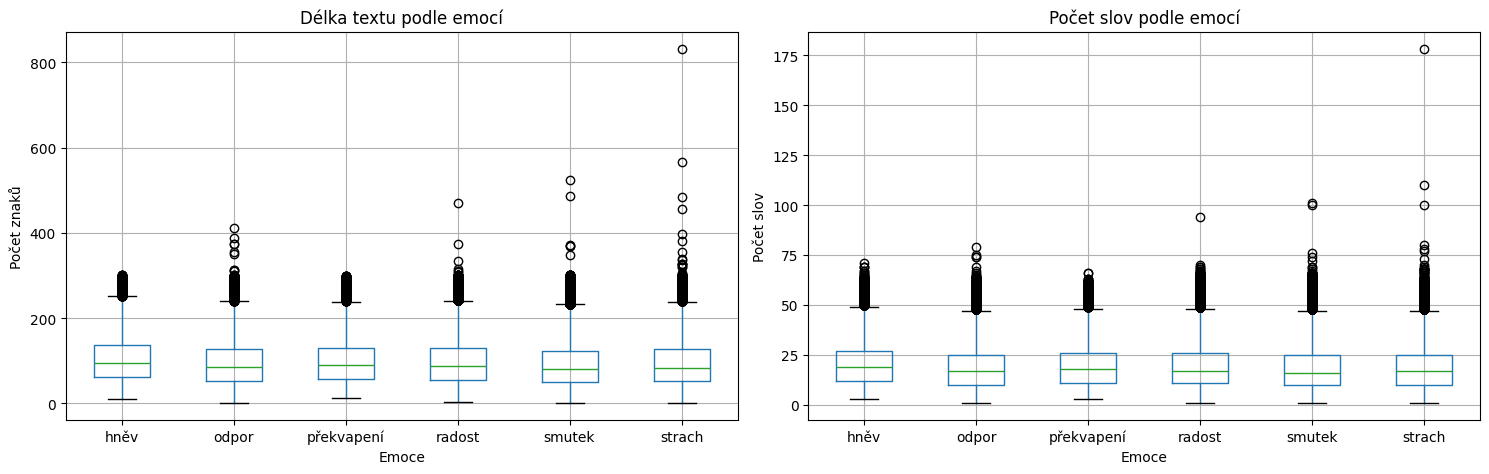

In [34]:
# Analýza délky textů
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("=== STATISTIKY DÉLKY TEXTŮ ===")
print(df[['text_length', 'word_count']].describe())

# Vizualizace délky textů podle emocí
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot pro délku textu
df.boxplot(column='text_length', by='emotion', ax=axes[0])
axes[0].set_title('Délka textu podle emocí')
axes[0].set_xlabel('Emoce')
axes[0].set_ylabel('Počet znaků')

# Box plot pro počet slov
df.boxplot(column='word_count', by='emotion', ax=axes[1])
axes[1].set_title('Počet slov podle emocí')
axes[1].set_xlabel('Emoce')
axes[1].set_ylabel('Počet slov')

plt.suptitle('')
plt.tight_layout()
plt.show()

# Předzpracování textu

In [35]:
def clean_text(text):
    """Základní čištění textu"""
    # Převod na malá písmena
    text = text.lower()

    # Odstranění URL
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Odstranění emailů
    text = re.sub(r'\S+@\S+', '', text)

    # Odstranění @mentions a #hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Odstranění speciálních znaků a číslic
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Odstranění extra mezer
    text = ' '.join(text.split())

    return text



In [41]:
# Aplikace předzpracování na celý dataset
print("Předzpracování textů...")

# Vytvoření různých verzí předzpracovaného textu
df['text'] = df['text'].apply(clean_text)




Předzpracování textů...


In [42]:
REDUCE_DATASET = False
if REDUCE_DATASET:
  data = data.sample(5000)

In [43]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)
y = to_categorical(df['label'], num_classes=num_classes)
y

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [44]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'].fillna(""))
sequences = tokenizer.texts_to_sequences(df['text'].fillna(""))
X = pad_sequences(sequences, maxlen=50, padding='post')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(333447, 50) (333447, 6)
(83362, 50) (83362, 6)


In [48]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=50),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 260s 50ms/step - accuracy: 0.3391 - loss: 1.5718 - val_accuracy: 0.3385 - val_loss: 1.5725
Epoch 2/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 273s 52ms/step - accuracy: 0.3546 - loss: 1.5157 - val_accuracy: 0.8268 - val_loss: 0.5346
Epoch 3/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 309s 50ms/step - accuracy: 0.9045 - loss: 0.2501 - val_accuracy: 0.9342 - val_loss: 0.1137
Epoch 4/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 260s 50ms/step - accuracy: 0.9384 - loss: 0.1032 - val_accuracy: 0.9372 - val_loss: 0.0993
Epoch 5/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 283s 54ms/step - accuracy: 0.9403 - loss: 0.0963 - val_accuracy: 0.9383 - val_loss: 0.0989
Epoch 6/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 325s 55ms/step - accuracy: 0.9428 - loss: 0.0900 - val_accuracy: 0.9387 - val_loss: 0.0975
Epoch 7/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 301s 51ms/step - accuracy: 0.9436 - loss: 0.0872 - val_accuracy: 0.9371 - val_loss: 0.1013
Epoch 8/10
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 266s 51ms/step - accuracy: 

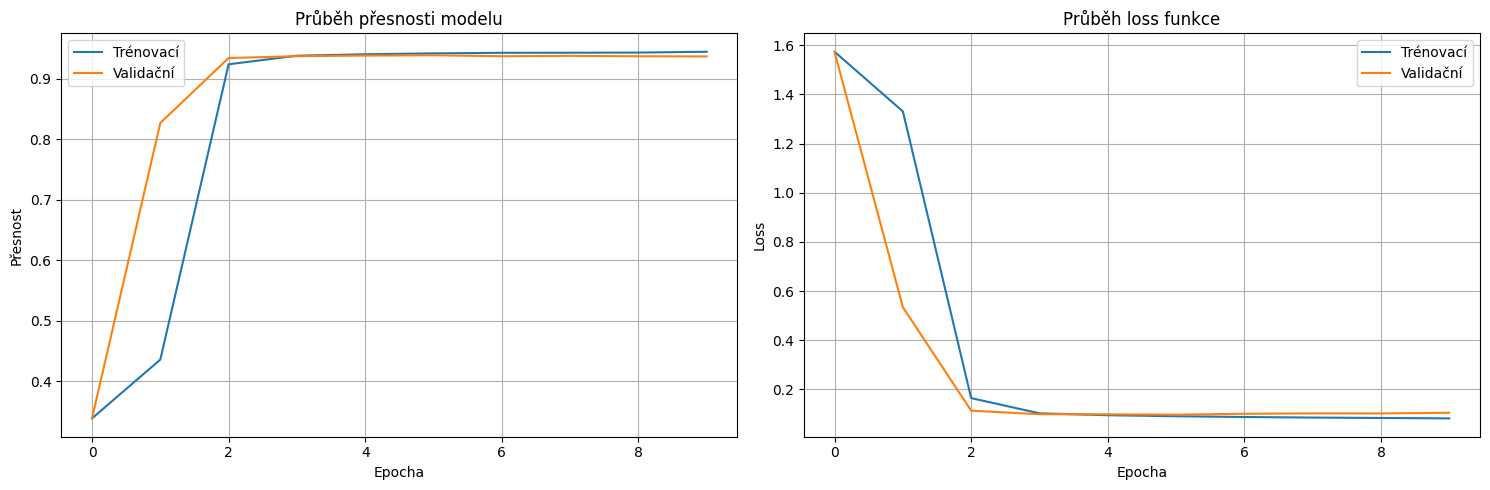


LSTM Test Accuracy: 0.9368


In [ ]:
# Vizualizace průběhu trénování
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Trénovací')
axes[0].plot(history.history['val_accuracy'], label='Validační')
axes[0].set_title('Průběh přesnosti modelu')
axes[0].set_xlabel('Epocha')
axes[0].set_ylabel('Přesnost')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Trénovací')
axes[1].plot(history.history['val_loss'], label='Validační')
axes[1].set_title('Průběh loss funkce')
axes[1].set_xlabel('Epocha')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Vyhodnocení na testovacích datech
lstm_loss, lstm_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")

In [ ]:
for index in chyby_indexy:
  print(df_train[index, "text"])

NameError: name 'chyby_indexy' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/best_emotion_model.keras"

# Save model and tokenizer
model.save(output_dir)